<a href="https://colab.research.google.com/github/Edenshmuel/PapaJohns_Data_Science_Project/blob/Nadav/DeepAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries:

In [1]:
# 🔧 Built-in Python libraries
from datetime import datetime, timedelta
from pathlib import Path
import os

# 💻 Google Colab utilities
from google.colab import drive, files

# 📊 Data manipulation
import pandas as pd
import numpy as np

# 📈 Visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 📐 Machine Learning metrics
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error)

# 🔮 Time Series Forecasting (GluonTS - DeepAR)
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# Install required packages

In [2]:
# !pip install pip==23.2.1                        # Ensure compatible pip version
# !pip install gluonts==0.10.7 mxnet==1.8.0.post0  # GluonTS with compatible MXNet
# !pip install numpy==1.23 scipy==1.9.3           # Specific versions required for GluonTS compatibility

In [3]:
drive.flush_and_unmount()

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Final_Project_PapaJohns/cleaned_data.csv')

In [6]:
desc_encoding_map = pd.read_csv('/content/drive/MyDrive/Final_Project_PapaJohns/Desc_encoding_map.csv')

desc_encoding_map.columns = ['Description', 'Clean_Desc_Encoded']
desc_encoding_map["Clean_Desc_Encoded"] = desc_encoding_map["Clean_Desc_Encoded"].astype(int)

In [7]:
df.to_csv("historical_data.csv", index=False)
files.download("historical_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# --- קלט מהמשתמש ---
start_input = input("הזן תאריך התחלה לחיזוי (YYYY-MM-DD): ")
start_date = pd.to_datetime(start_input)
end_date   = start_date + pd.Timedelta(days=30)  # תמיד 31 ימים כולל התאריך ההתחלתי

today = pd.to_datetime(datetime.today().date())

# --- בדיקות תוקף ---
if start_date <= today:
    raise ValueError("⛔ תאריך ההתחלה חייב להיות מחר או מאוחר יותר.")

# --- חישוב טווח התחזית ---
range_days = 31  # תמיד קבוע כי המודל תומך רק בזה

# --- הדפסת סיכום ---
print(f"📆 טווח התחזית: {start_date.date()} עד {end_date.date()} ({range_days} ימים)")

הזן תאריך התחלה לחיזוי (YYYY-MM-DD): 2025-08-01
📆 טווח התחזית: 2025-08-01 עד 2025-08-31 (31 ימים)


In [9]:
def generate_forecast_series(
        df,
        start_date,
        prediction_length,
        dynamic_features_cols,
        item_col="Clean_Desc_Encoded",
        target_col="Quantity",
        freq="D"):

    # קביעת תאריך סיום לפי prediction_length קבוע
    end_date = start_date + pd.Timedelta(days=prediction_length - 1)
    series_list = []

    for item_id in df[item_col].unique():
        df_item = df[df[item_col] == item_id].copy()

        # --- 1) real historical data only --------------------------
        df_hist = df_item[df_item["Date"] < start_date].sort_values("Date")
        if df_hist.empty:
            continue

        # --- 2) full range (past + future) for dynamic features -------
        full_dates = pd.date_range(
            start=df_hist["Date"].iloc[0],
            end=end_date,
            freq=freq
        )
        df_full = pd.DataFrame({"Date": full_dates})
        df_full[item_col] = item_id
        cols_to_merge = [c for c in df_item.columns if c != target_col]
        df_full = (
            df_full
            .merge(df_item[cols_to_merge], on=["Date", item_col], how="left")
            .sort_values("Date")
        )

        target_hist = df_hist[target_col].astype(float).values

        # יצירת פיצ'רים עונתיים
        df_full["Year"]  = df_full["Date"].dt.year
        df_full["Month"] = df_full["Date"].dt.month
        df_full["Day"]   = df_full["Date"].dt.day
        df_full["WeekOfYear"] = df_full["Date"].dt.isocalendar().week
        df_full["Day_Name"]   = df_full["Date"].dt.day_name()

        df_full["is_weekend"]        = (df_full["Date"].dt.dayofweek >= 5).astype(int)
        df_full["is_start_of_month"] = df_full["Date"].dt.is_month_start.astype(int)
        df_full["is_end_of_month"]   = df_full["Date"].dt.is_month_end.astype(int)

        df_full["Day_Name_sin"] = np.sin(2 * np.pi * df_full["Date"].dt.dayofweek / 7)
        df_full["Day_Name_cos"] = np.cos(2 * np.pi * df_full["Date"].dt.dayofweek / 7)
        df_full["Month_sin"]    = np.sin(2 * np.pi * df_full["Month"] / 12)
        df_full["Month_cos"]    = np.cos(2 * np.pi * df_full["Month"] / 12)

        # השלמת פיצ'רים דינמיים
        for col in dynamic_features_cols:
            if col not in df_full.columns:
                df_full[col] = 0
            df_full[col] = (df_full[col]
                            .fillna(method="ffill")
                            .fillna(method="bfill")
                            .fillna(0))

        feat_dynamic_real = df_full[dynamic_features_cols].T.values.tolist()

        # --- 3) record for time series -----------------------------------
        series_list.append({
            "start": df_hist["Date"].iloc[0],
            "target": target_hist,
            "feat_dynamic_real": feat_dynamic_real,
            "item_id": str(item_id),
        })

    return series_list

In [10]:
df["Date"] = pd.to_datetime(df["Date"])

In [11]:
# List of dynamic features
dynamic_features_cols = [
    'Year', 'Month', 'Day', 'Is_Weekend',
    'is_christian_holiday', 'is_jewish_holiday',
    'is_near_jewish_holiday', 'is_day_before_new_year',
    'category_encoded', 'WeekOfYear', 'Season',
    'is_start_of_month', 'is_end_of_month',
    'Day_Name_sin', 'Day_Name_cos', 'Month_sin', 'Month_cos',
    'encoded_jewish_holiday', 'encoded_christian_holiday'
]

# Columns to drop (if any are in dynamic_features list)
columns_to_drop_dynamic = [
    'portion_type',
    'avg_quantity_all_time',
    'std_quantity_all_time',
    'num_days_sold',
    'popularity_score'
]

# Remove unwanted dynamic features
dynamic_features_cols = [
    col for col in dynamic_features_cols if col not in columns_to_drop_dynamic]

# Filter out categories with less than 50 sales
filtered_df = (
    df.groupby("Clean_Desc_Encoded")
    .filter(lambda g: len(g) >= 50)
)

# Use fixed prediction_length (must match model training)
prediction_length = 31

# Generate input series
series_list = generate_forecast_series(
    df=filtered_df,
    start_date=start_date,
    prediction_length=prediction_length,
    dynamic_features_cols=dynamic_features_cols
)

# Create GluonTS datasets
training_ds = ListDataset(series_list, freq="D")
test_ds     = ListDataset(series_list, freq="D")

In [12]:
estimator = DeepAREstimator(
    freq="D",
    prediction_length=prediction_length,
    context_length=prediction_length * 6,
    cell_type="gru",
    num_layers=2,
    trainer=Trainer(ctx="cpu", epochs=50, learning_rate=1e-3, weight_decay=1e-5))

predictor = estimator.train(training_ds)

100%|██████████| 50/50 [00:34<00:00,  1.44it/s, epoch=50/50, avg_epoch_loss=-0.235]


# Saving the trained model to a folder

In [18]:
# Create a folder to save the model (if it doesn't exist)
model_dir = Path("deepar_model")
model_dir.mkdir(exist_ok=True)

# Saving the trained model
predictor.serialize(model_dir)

In [19]:
import pickle

with open("predictor.pkl", "wb") as f:
    pickle.dump(predictor, f)

In [20]:
from shutil import move
move("predictor.pkl", "deepar_model/predictor.pkl")

'deepar_model/predictor.pkl'

In [21]:
!zip -r deepar_model.zip deepar_model
files.download("deepar_model.zip")

updating: deepar_model/ (stored 0%)
updating: deepar_model/type.txt (deflated 11%)
updating: deepar_model/version.json (deflated 18%)
updating: deepar_model/parameters.json (deflated 48%)
updating: deepar_model/input_transform.json (deflated 80%)
updating: deepar_model/prediction_net-0000.params (deflated 9%)
updating: deepar_model/prediction_net-network.json (deflated 47%)
  adding: deepar_model/predictor.pkl (deflated 54%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
print(os.listdir("deepar_model"))

['type.txt', 'version.json', 'parameters.json', 'input_transform.json', 'predictor.pkl', 'prediction_net-0000.params', 'prediction_net-network.json']


In [14]:
test_ds = ListDataset(series_list, freq="D")

forecasts = {}

for entry, forecast in zip(test_ds, predictor.predict(test_ds)):
    cat_id = entry["item_id"]
    forecast_index = pd.date_range(start=start_date, periods=prediction_length, freq="D")

    df_forecast = pd.DataFrame({
        "date": forecast_index,
        "predicted_quantity": forecast.quantile(0.9)
    })

    df_forecast["predicted_quantity_ceiled"] = np.round(df_forecast["predicted_quantity"])
    forecasts[cat_id] = df_forecast

all_forecasts_list = []

for cat_id, df_cat in forecasts.items():
    df_cat["clean_desc_encoded"] = int(cat_id)
    all_forecasts_list.append(df_cat)

all_forecasts_df = pd.concat(all_forecasts_list, ignore_index=True)
desc_encoding_map.columns = ["desc_name", "clean_desc_encoded"]
all_forecasts_df = all_forecasts_df.merge(desc_encoding_map, on="clean_desc_encoded", how="left")
all_forecasts_df["predicted_quantity_ceiled"] = np.round(all_forecasts_df["predicted_quantity"])

all_forecasts_df.sort_values(["clean_desc_encoded", "date"]).head(30)

,date,predicted_quantity,predicted_quantity_ceiled,clean_desc_encoded,desc_name
0,2025-08-01,0.993353,1.0,0,ביאנקה 14
1,2025-08-02,0.991950,1.0,0,ביאנקה 14
2,2025-08-03,1.000769,1.0,0,ביאנקה 14
3,2025-08-04,0.994488,1.0,0,ביאנקה 14
4,2025-08-05,0.991588,1.0,0,ביאנקה 14
5,2025-08-06,0.988300,1.0,0,ביאנקה 14
6,2025-08-07,0.990164,1.0,0,ביאנקה 14
7,2025-08-08,0.997056,1.0,0,ביאנקה 14
8,2025-08-09,1.000014,1.0,0,ביאנקה 14
9,2025-08-10,0.997717,1.0,0,ביאנקה 14


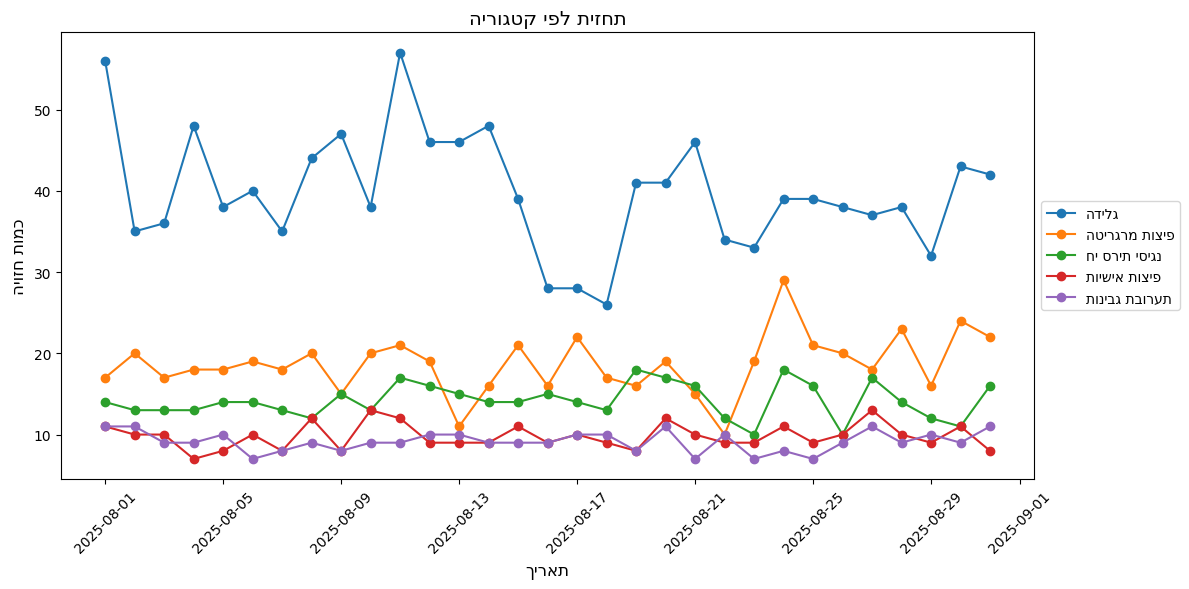

In [15]:
desc_name_map = desc_encoding_map.set_index("clean_desc_encoded")["desc_name"].to_dict()

top_ids = (
    all_forecasts_df.groupby("clean_desc_encoded")["predicted_quantity_ceiled"]
    .mean()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist())

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.figure(figsize=(12, 6))

for cat_id in top_ids:
    df_plot = forecasts[str(cat_id)]
    cat_name = desc_name_map.get(cat_id, f"קטגוריה {cat_id}")

    cat_name_rtl = cat_name[::-1]

    plt.plot(df_plot["date"], df_plot["predicted_quantity_ceiled"], marker='o', label=cat_name_rtl)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("תחזית לפי קטגוריה"[::-1], fontsize=14)
plt.xlabel("תאריך"[::-1], fontsize=12)
plt.ylabel("כמות חזויה"[::-1], fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Define evaluation date ranges
train_end_date_eval = pd.to_datetime("2024-09-30")
test_start_date_eval = pd.to_datetime("2024-10-01")
test_end_date_eval   = pd.to_datetime("2024-10-23")

# Calculate prediction length
prediction_length_eval = (test_end_date_eval - test_start_date_eval).days + 1

# Generate input series for evaluation
series_list_eval = generate_forecast_series(
    df=df[df["Date"] <= train_end_date_eval],
    start_date=test_start_date_eval,
    prediction_length=prediction_length_eval,
    dynamic_features_cols=dynamic_features_cols
)

# Wrap the series in a GluonTS-compatible dataset
test_ds_eval = ListDataset(series_list_eval, freq="D")

# Dictionary to store forecast DataFrames per item
forecasts_eval = {}

# Run prediction and build forecast DataFrames
for entry, forecast in zip(test_ds_eval, predictor.predict(test_ds_eval)):
    cat_id = entry["item_id"]
    pred_values = forecast.quantile(0.9)
    forecast_index = pd.date_range(start=test_start_date_eval, periods=len(pred_values), freq="D")

    forecasts_eval[cat_id] = pd.DataFrame({
        "date": forecast_index,
        "predicted_quantity": pred_values,
        "Clean_Desc_Encoded": [int(cat_id)] * len(pred_values)
    })

# Combine all item forecasts into a single DataFrame
all_forecasts_eval_df = pd.concat(list(forecasts_eval.values()), ignore_index=True)

In [20]:
all_forecasts_eval_df["predicted_quantity_ceiled"] = np.round(all_forecasts_eval_df["predicted_quantity"])

eval_df = (
    all_forecasts_eval_df
    .merge(
        df[["Date", "Clean_Desc_Encoded", "Quantity"]],
        left_on=["date", "Clean_Desc_Encoded"],
        right_on=["Date", "Clean_Desc_Encoded"],
        how="inner"
    )
    .rename(columns={"Quantity": "Actual", "predicted_quantity_ceiled": "Predicted"})
)

eval_df = eval_df[eval_df["Actual"] > 0].dropna(subset=["Predicted"])

y_true = eval_df["Actual"].reset_index(drop=True)
y_pred = eval_df["Predicted"].reset_index(drop=True)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

smape = 100 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

naive_forecast = y_true.shift(1).dropna()
mase_denominator = np.mean(np.abs(naive_forecast.values - y_true[1:].values))
mase = mae / mase_denominator if mase_denominator != 0 else np.nan

try:
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
except ImportError:
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Model Evaluation Results on Test Set:")
print(f"MAE:         {mae:.2f}")
print(f"RMSE:        {rmse:.2f}")
print(f"SMAPE:       {smape:.2f}%")
print(f"MASE:        {mase:.4f}")
print(f"MAPE:        {mape:.2f}%")

Model Evaluation Results on Test Set:
MAE:         0.27
RMSE:        1.02
SMAPE:       13.41%
MASE:        0.8737
MAPE:        11.77%


In [21]:
desc_encoding_map.columns = ["desc_name", "Clean_Desc_Encoded"]
eval_df = eval_df.merge(desc_encoding_map, on="Clean_Desc_Encoded", how="left")

metrics_per_cat = (
    eval_df
    .groupby(["Clean_Desc_Encoded", "desc_name"])
    .apply(lambda g: pd.Series({
        "MAE": mean_absolute_error(g["Actual"], g["Predicted"]),
        "RMSE": np.sqrt(mean_squared_error(g["Actual"], g["Predicted"])),
        "R²": r2_score(g["Actual"], g["Predicted"]) if len(g) > 1 else np.nan,
        "MAPE": np.mean(np.abs((g["Actual"] - g["Predicted"]) / g["Actual"])) * 100
    }))
    .reset_index())

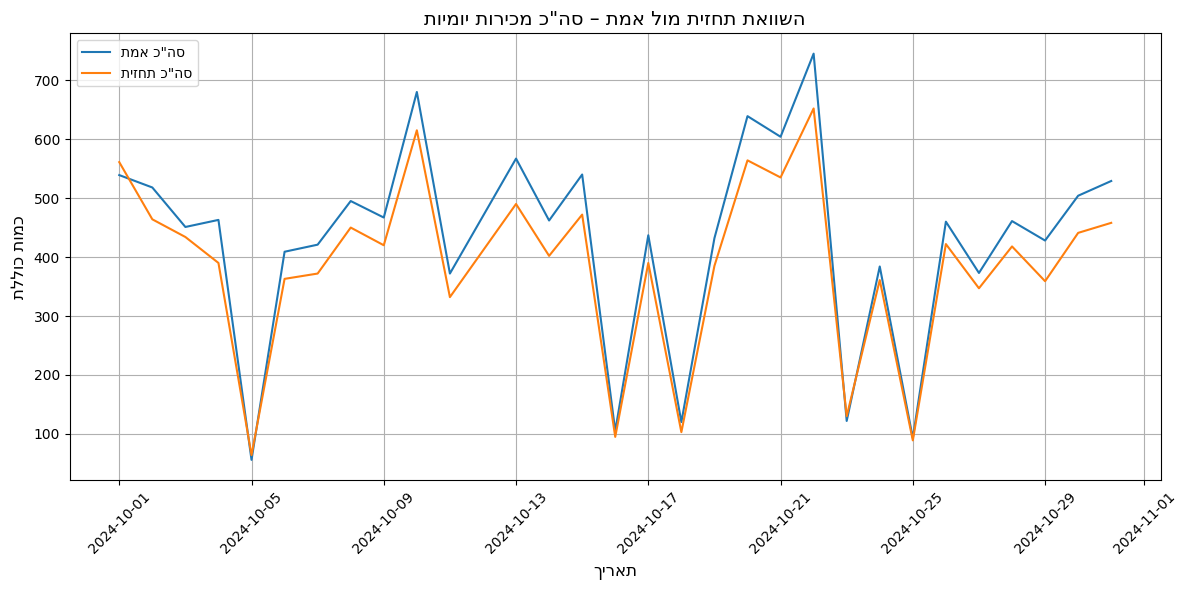

In [22]:
plt.rcParams["font.family"] = "DejaVu Sans"
def rtl(text):
    return text[::-1]

daily_summary = eval_df.groupby("date").agg({
    "Actual": "sum",
    "Predicted": "sum"
}).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_summary, x="date", y="Actual", label=rtl("סה\"כ אמת"))
sns.lineplot(data=daily_summary, x="date", y="Predicted", label=rtl("סה\"כ תחזית"))

plt.title(rtl("השוואת תחזית מול אמת – סה\"כ מכירות יומיות"), fontsize=14)
plt.xlabel(rtl("תאריך"), fontsize=12)
plt.ylabel(rtl("כמות כוללת"), fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [23]:
eval_df = all_forecasts_eval_df.merge(
    df[["Date", "Clean_Desc_Encoded", "Quantity"]],
    left_on=["date", "Clean_Desc_Encoded"],
    right_on=["Date", "Clean_Desc_Encoded"],
    how="inner"
).rename(columns={"Quantity": "Actual", "Predicted_quantity": "Predicted"})

eval_df = eval_df[eval_df["Actual"] > 0]

eval_df = eval_df.merge(desc_encoding_map, on="Clean_Desc_Encoded", how="left")
eval_df["date"].sort_values().unique()
eval_df.head(30)

,date,predicted_quantity,Clean_Desc_Encoded,predicted_quantity_ceiled,Date,Actual,desc_name
0,2024-10-01,0.995184,0,1.0,2024-10-01,1,ביאנקה 14
1,2024-10-01,0.995184,0,1.0,2024-10-01,1,ביאנקה 14
2,2024-10-01,0.995184,0,1.0,2024-10-01,1,ביאנקה 14
3,2024-10-07,0.990760,0,1.0,2024-10-07,1,ביאנקה 14
4,2024-10-08,0.995573,0,1.0,2024-10-08,1,ביאנקה 14
5,2024-10-08,0.995573,0,1.0,2024-10-08,1,ביאנקה 14
6,2024-10-08,0.995573,0,1.0,2024-10-08,1,ביאנקה 14
7,2024-10-13,0.993130,0,1.0,2024-10-13,1,ביאנקה 14
8,2024-10-13,0.993130,0,1.0,2024-10-13,1,ביאנקה 14
9,2024-10-15,1.001348,0,1.0,2024-10-15,1,ביאנקה 14
